## Data Augmentation

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2, yaml
import math
import rotation as rot

### Load calibration data

In [2]:
with open('ost.yaml','r') as calib_file :
    calib_data = yaml.load(calib_file)
    
# camera projection matrix :
projection_matrix = calib_data['projection_matrix']
P_ = np.array(projection_matrix['data'])
P_ = P_.reshape((projection_matrix['rows'],projection_matrix['cols']))
print("Projection matrix : \n", P_)


# lidar-camera calibration : 
tx, ty, tz, yaw, pitch, roll = [0.00749025, -0.40459941, -0.51372948, 
                                        -1.66780896, -1.59875352, -3.05415572]
translation = [tx, ty, tz, 1]
R_ = rot.euler_matrix(roll, pitch, yaw)
R_[:, 3] = translation
print("\nLidar-camera calibration matrix : \n", R_)

Projection matrix : 
 [[  1.36218469e+03   0.00000000e+00   6.20575531e+02   0.00000000e+00]
 [  0.00000000e+00   1.37230579e+03   5.61873133e+02   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00]]

Lidar-camera calibration matrix : 
 [[ 0.0027076  -0.99995085 -0.00953785  0.00749025]
 [ 0.02782211  0.00960952 -0.9995667  -0.40459941]
 [ 0.99960922  0.00244106  0.02784676 -0.51372948]
 [ 0.          0.          0.          1.        ]]


### utils 

Some useful functions :

In [3]:
# BGR to RGB conversion for opencv to matplotlib format
def BGR2RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# project 3D points to camera plane
def project_points(points) :
    projected_points = []
    for point in points:
        X = np.append(point, 1)
        X = R_.dot(X)
        U = P_.dot(X)
        projected_points.append(U[:2]/U[2])
    return projected_points

# draw bbox on camera image
def drawBbox(img, corners, color=(255,255,0)) :
    image = np.copy(img)
    thickness = 10
    for i in range(4) :
        pt1, pt2 = corners[2*i], corners[2*i+1]
        cv2.line(image, tuple(pt1.astype(int)), tuple(pt2.astype(int)), 
                 color=color, thickness=thickness)

        pt1, pt2 = corners[i+2*(i//2)], corners[3-i+6*(i//2)]
        cv2.line(image, tuple(pt1.astype(int)), tuple(pt2.astype(int)), 
                 color=color, thickness=thickness)

        pt1, pt2 = corners[i], corners[i+4]
        cv2.line(image, tuple(pt1.astype(int)), tuple(pt2.astype(int)), 
                 color=color, thickness=thickness)
    return image

# display data
def display(top_slices=None, camera_img=None, gt_bbox=None):
    if gt_bbox is not None :
        corners = gt_bbox.squeeze()
        projected_corners = project_points(corners)
        if camera_img is not None :
            camera_img = drawBbox(camera_img, projected_corners)
    
    fig_count =0
    if camera_img is not None:
        fig_count+=1
        plt.figure(fig_count)
        plt.imshow(BGR2RGB(camera_img))
        plt.title('Camera image')
        plt.axis('off')
    else :
        print('No camera image available.')
    
    if top_slices is not None:
        fig_count+=1
        plt.figure(fig_count)
        n_height_maps = top_slices.shape[2]
        fig, axes = plt.subplots(1, n_height_maps, figsize=(15,8))
        labels = ['height_'+str(i+1) for i in range(n_height_maps-2)]+['Intensity','Density']

        for i, ax in enumerate(axes) :
            top = top_slices[:,:,i]
            ax.imshow(top, cmap="hot")
            ax.set_title(labels[i])
            ax.axis('off')
        
# perspective transform camera image using bbox points  
def transform_image(img, bbox_src, bbox_dst) :
    projected_pts_src = project_points(bbox_src)
    projected_pts_dst = project_points(bbox_dst)
    M1 = cv2.getPerspectiveTransform(np.float32(projected_pts_src[2:6]),
                                np.float32(projected_pts_dst[2:6]))
    M2 = cv2.getPerspectiveTransform(np.float32(projected_pts_src[:4]),
                                np.float32(projected_pts_dst[:4]))
    M = (M1+M2)/2
    rows,cols = img.shape[:2]
    new_img = cv2.warpPerspective(img,M,(cols,rows))
    return new_img

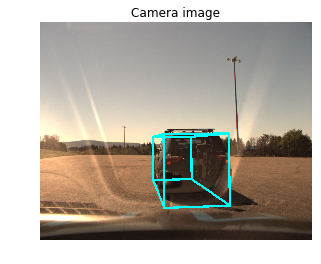

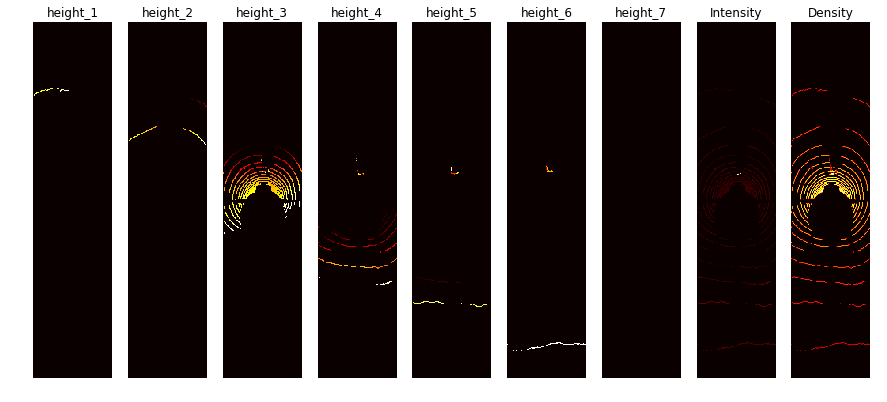

In [4]:
data_dir = '/home/prerit/DiDi/MV3D/data/preprocessed/didi'
bag_group = '1'
bag = '6_f'
frame = 0

frame_label = str(frame).zfill(5)
top_slices = np.load(os.path.join(data_dir, 'top', bag_group, bag, frame_label+'.npy'))
camera_img = cv2.imread(os.path.join(data_dir, 'rgb', bag_group, bag, frame_label+'.png'))
gt_bbox    = np.load(os.path.join(data_dir, 'gt_boxes3d', bag_group, bag, frame_label+'.npy'))

display(top_slices, camera_img, gt_bbox)

## Flip about velodyne x=0 plane or y=0 plane

While the velodyne flip is easy, the corresponding flip in the camera image is non-trivial due to offset in camera-velodyne frames. 

* use axis=0 for flip about x=0 plane (the yz plane) : Obviously no camera image is available for this option. 
* use axis=1 for flip about y=0  plane (the xz plane)

In [5]:
def flip(data_dir = '/home/prerit/DiDi/MV3D/data/preprocessed/didi', 
         bag_group = '1', 
         bag = '6_f',
         frame = 0,
         axis = 1) :
    assert (axis==0) or (axis==1) , "axis can be 0 or 1."
    frame_label = str(frame).zfill(5) 
    tops = np.load(os.path.join(data_dir, 'top', bag_group, bag, frame_label+'.npy'))
    rgb = cv2.imread(os.path.join(data_dir, 'rgb', bag_group, bag, frame_label+'.png'))
    bbox = np.load(os.path.join(data_dir, 'gt_boxes3d', bag_group, bag, frame_label+'.npy'))
    bbox = bbox.squeeze()
    bbox_new = np.copy(bbox)
    bbox_new[:,axis] = -bbox_new[:,axis]
    if axis==1 :
        rgb_new = transform_image(rgb, bbox, bbox_new)
    else :
        rgb_new = None
    tops_new = cv2.flip(tops,axis)
    return (tops_new, rgb_new, bbox_new)

### Flip about x=0 plane

No camera image available.


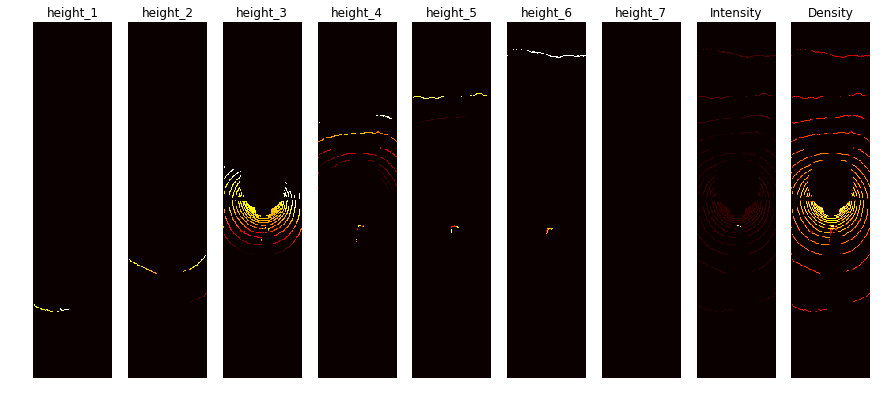

In [6]:
top_slices, camera_img, gt_bbox = flip(bag_group = '1', bag = '6_f', frame=0, axis=0)
display(top_slices, camera_img, gt_bbox)

### Flip about y=0 plane

Notice the non-trivial flip in camera image

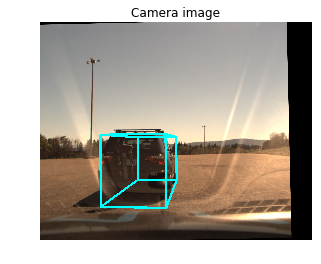

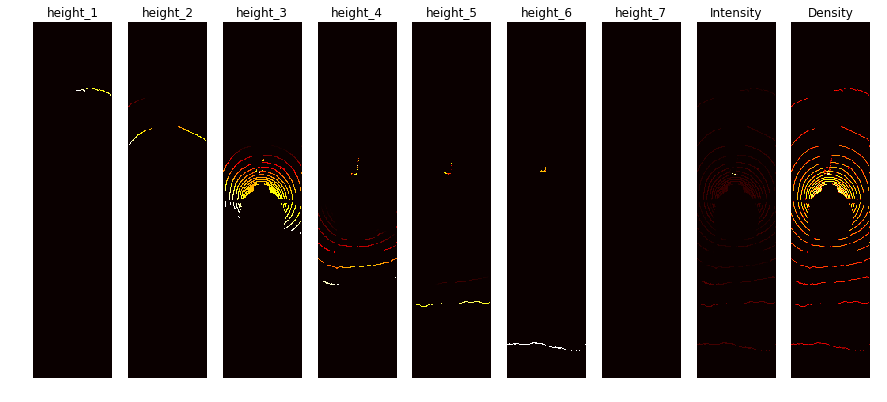

In [7]:
top_slices, camera_img, gt_bbox = flip(bag_group = '1', bag = '6_f', frame=0, axis=1)
display(top_slices, camera_img, gt_bbox)

## Rotation about velodyne z-axis

theta is in degrees, counter-clockwise rotation

If theta>30 degrees, only lidar top view is returned

In [8]:
def rotate(data_dir = '/home/prerit/DiDi/MV3D/data/preprocessed/didi', 
         bag_group = '1', 
         bag = '6_f',
         frame = 0,
         theta = 20) :

    frame_label = str(frame).zfill(5) 
    tops = np.load(os.path.join(data_dir, 'top', bag_group, bag, frame_label+'.npy'))
    rgb = cv2.imread(os.path.join(data_dir, 'rgb', bag_group, bag, frame_label+'.png'))
    bbox = np.load(os.path.join(data_dir, 'gt_boxes3d', bag_group, bag, frame_label+'.npy'))
    bbox = bbox.squeeze()
    rows,cols = tops.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1)
    tops_new = cv2.warpAffine(tops,M,(cols,rows))
    R = rot.rotMatZ(theta/180*math.pi)
    bbox_new = np.array([R.dot(corner) for corner in bbox])
    if theta > 30 :
        return (tops_new, None, bbox_new)
    rgb_new = transform_image(rgb, bbox, bbox_new) 
    return (tops_new, rgb_new, bbox_new)

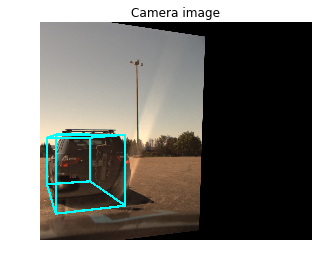

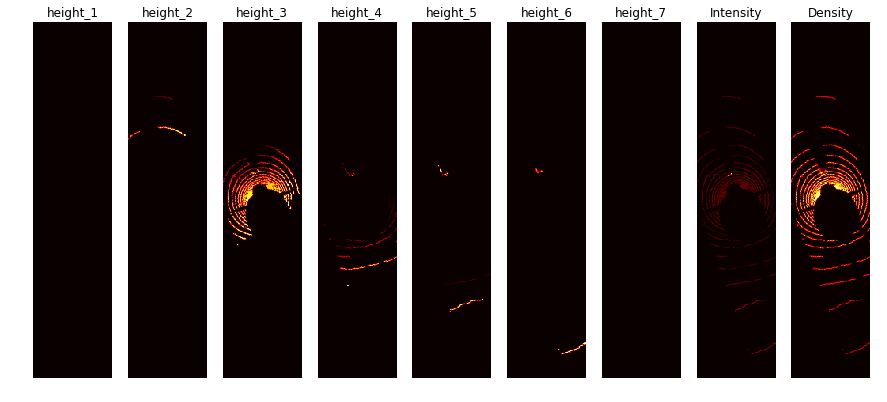

In [9]:
tops_new, rgb_new, bbox_new = rotate(bag_group = '1', bag = '6_f',frame=0, theta=20)
display(tops_new, rgb_new, bbox_new)